In [1]:
#default_exp icao_datasets

In [5]:
#export
from fastai import *
from fastai.vision import *
from pathlib import PosixPath
import cv2
from shutil import copyfile

In [6]:
import matplotlib.pyplot as plt

def plot(im, figsize=None): # im - np.arr(h,w,3), figsize - tuple(2)
    ax = plt.figure(figsize=figsize)
    if len(im.squeeze().shape) == 2: plt.imshow(im, cmap='gray')
    else: plt.imshow(im)
    return plt.show()

def plot_histogram(arr, title=None, bins=None): # arr of size [n], bins-'auto'
    _ = plt.hist(arr, bins=bins)  # arguments are passed to np.histogram
    plt.title(title)
    plt.show()
    
def plot_categories(names, values, title='names'): # arr of size [n]
    df = pd.DataFrame({title:listify(names), 'val':listify(values)})
    df.plot.bar(x=title, y='val', rot=90)

# plot_histogram( np.random.RandomState(10).normal(size=1000) )
# plot_categories(['a','b','c'], [1,2,3])

### VGG2 face bboxes

In [42]:
bb_path = Path('/data/faces/VGG2/bb_landmark/loose_bb_train.csv')
vgg_im2bbox = {} # NOTE: key is w/out stem (.jpg) -> t,l,b,r
for i,line in enumerate(progress_bar(open(bb_path).readlines()[1:])):
    im_name, x,y,w,h = line[:-1].split(',')
    x,y,w,h = map(int, [x,y,w,h])
    vgg_im2bbox[im_name[1:-1]] = (max(y,0),max(x,0),y+h,x+w)

# MouthOpen

In [10]:
out_path = Path('../data/icao/mouthopen_frontal_vgg/')
MOUTH_OPEN, MOUTH_CLOSED = 'MouthOpen', 'MouthClosed'
try: (out_path/MOUTH_CLOSED).mkdir(); (out_path/MOUTH_OPEN).mkdir()
except: print('dirs already exist')

dirs already exist


In [ ]:
def prepare_dataset():
    out_path = Path('../data/icao/mouthopen/')
    vgg_train_path = Path('/data/faces/VGG2/train/')
    vgg_attr_path = Path('/data/faces/VGG2/attributes/11-Mouth_Open.txt')
    doesnt_exist = 0
    ims = []
    for line in progress_bar(open(vgg_attr_path).readlines()):
        img_str, lbl_str = line[:-1].split('\t')
        ims.append(img_str)
        label = MOUTH_OPEN if lbl_str == '1' else MOUTH_CLOSED
        img_path = vgg_train_path/img_str
        if not img_path.exists(): doesnt_exist += 1
        else:
            t,l,b,r = vgg_im2bbox[ img_str[:-4] ]
            image = Image(open_image(img_path).data[:,t:b,l:r])
            image.save(out_path/label/'_'.join(img_str.split('/')))
    print('doesnt exist:', doesnt_exist)
# prepare_dataset()

In [ ]:
images_dir = Path('../data/vgg_frontal_faces_hd/')
frontal_faces = [str(x).split('/')[-1] for x in images_dir.iterdir()] # personid_imgid.jpg

In [ ]:
def prepare_frontal_dataset():
    out_path = Path('../data/icao/mouthopen_frontal_vgg/')
    vgg_train_path = Path('/data/faces/VGG2/train/')
    vgg_attr_path = Path('/data/faces/VGG2/attributes/11-Mouth_Open.txt')
    not_frontal = 0
    ims = []
    for line in progress_bar(open(vgg_attr_path).readlines()):
        img_str, lbl_str = line[:-1].split('\t')
        ims.append(img_str)
        label = MOUTH_OPEN if lbl_str == '1' else MOUTH_CLOSED
        img_path = vgg_train_path/img_str
        if img_str.replace('/','_') not in frontal_faces: not_frontal += 1
        else:
            t,l,b,r = vgg_im2bbox[ img_str[:-4] ]
            image = Image(open_image(img_path).data[:,t:b,l:r])
            image.save(out_path/label/'_'.join(img_str.split('/')))
    print('not_frontal:', not_frontal)
# prepare_frontal_dataset()

### MouthOpen TestData

In [34]:
testdata_dir = Path('../data/icao/mouthopen_testdata/')

In [35]:
from facelib.labeling_icao import Labeler
openmouth_imagedir = Path('../data/icao/mouthopen_celeba_black/MouthOpen/')
images = [str(path) for path in openmouth_imagedir.iterdir()]
json_outputdir = Path('../data/icao/json_labels_mouthslightlyopen/')
labeler = Labeler(['MouthSlightlyOpen'], images, output_dir=json_outputdir, label_labeled=False)
labeler.show_next_batch()

In [36]:
openmouth_imagedir = Path('../data/face/cropped_celeba/')

In [37]:
good_im_names = [path.name[:-5] for path in json_outputdir.iterdir() if json.load(open(path))['labels']['MouthSlightlyOpen'] == 'green']
len(good_im_names)

102

In [38]:
for name in good_im_names: open_image(openmouth_imagedir/name).save(testdata_dir/MOUTH_OPEN/name)

### MouthClosed TestData

In [26]:
from facenet_pytorch import MTCNN
mtcnn = MTCNN(
    image_size=224, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False,
    device='cpu'
)

from torchvision import datasets
class ImagesWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super().__getitem__(index)
        path = self.imgs[index][0]
        return (original_tuple + (path,))
    
def create_cropped_images(loader, output_dir):
    not_found_names = []
    for x, y, path in progress_bar(loader):
        name = Path(path).name
        try:Image(mtcnn(x)/255.).save(str(output_dir/name))
        except: not_found_names.append(Path(path).name)
    return not_found_names

In [31]:
mouthclosed_dirpath = Path('/data/faces/IC_6K_MATCHES/HITS/')
dataset = ImagesWithPath(str(mouthclosed_dirpath.parent))
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=lambda x: x[0], num_workers=1)
create_cropped_images(loader, testdata_dir/MOUTH_CLOSED)

In [32]:
from facelib.core import read_dict, save_dict
save_dict(list(map(lambda p:p.name, get_image_files(testdata_dir, recurse=True))), '../data/icao/mouthopen_testdata.pkl')

# Glasses

In [39]:
SUNGLASSES, EYEGLASSES, NOGLASSES = 'SunGlasses', 'EyeGlasses', 'NoGlasses'

In [43]:
def prepare_glasses_dataset():
    out_path = Path('../data/icao/glasses_vgg/')
    vgg_train_path = Path('/data/faces/VGG2/train/')
    vgg_attr_eyeglasses_path = Path('/data/faces/VGG2/attributes/09-Eyeglasses.txt')
    vgg_attr_sunglasses_path = Path('/data/faces/VGG2/attributes/10-Sunglasses.txt')
    doesnt_exist = 0
    ims = []
    sun_lines, eye_lines = map(lambda path: open(path).readlines(), [vgg_attr_sunglasses_path, vgg_attr_eyeglasses_path])
    for sun_line, eye_line in progress_bar(list(zip(sun_lines, eye_lines))):
        img_str_eye, lbl_str_eye = eye_line[:-1].split('\t')
        img_str_sun, lbl_str_sun = sun_line[:-1].split('\t')
        assert img_str_eye == img_str_sun
        img_str = img_str_eye
        ims.append(img_str)
        label = EYEGLASSES if lbl_str_eye == '1' else NOGLASSES
        if lbl_str_sun == '1': label = SUNGLASSES
        img_path = vgg_train_path/img_str
        if not img_path.exists(): doesnt_exist += 1
        else:
            t,l,b,r = vgg_im2bbox[ img_str[:-4] ]
            image = Image(open_image(img_path).data[:,t:b,l:r])
            image.save(out_path/label/'_'.join(img_str.split('/')))
    print('doesnt exist:', doesnt_exist)
prepare_glasses_dataset()

doesnt exist: 0


# LookingAway

In [73]:
def read_json(data_name, first=True):
    out = {}
    FACE_PATH = Path("/data/faces/")
    PATH = FACE_PATH/"unlabeled"
    for file_path in PATH.iterdir():
        fn = str(file_path).split('/')[-1]
        if fn.startswith('labels_'+data_name):
            if first:
                out.update( json.load(open(file_path)) )
                first = False
            else:
                out['images'].extend( json.load(open(file_path))['images'] )
    return out

In [80]:
data_name = 'fc'
j = read_json(data_name)
# images_dirpath = Path("/data/faces/unlabeled/images_"+data_name)
images_dirpath = Path("/data/faces/unlabeled/images")

In [129]:
def parse_points(pts_string):
    ''' 'x,y,w,h' or 'x,y' '''
    return list(map(int, pts_string.split(',')))

In [157]:
def get_lookingaway_images(data_name):
    j = read_json(data_name)
    # images_dirpath = Path("/data/faces/unlabeled/images_"+data_name)
    images_dirpath = Path("/data/faces/unlabeled/images")
    lbl2idx = {v:k for k,v in j['face_args'].items()}
    icaos = [(x['path'], x['faces'][0][lbl2idx['IcaoWarnings']], x['faces'][0][lbl2idx['LookingAwayConfidence']], 
              parse_points(x['faces'][0][lbl2idx['BoundingRect']])) for x in j['images']]
    lookingaway_images = [(images_dirpath/name,bb) for name,x,conf,bb in icaos if ('LookingAway' in x and -1 < conf and conf < 10)]
    lookingtocamera_images = [(images_dirpath/name,bb) for name,x,conf,bb in icaos if ('LookingAway' not in x and 85 < conf and conf < 101)]
    return lookingtocamera_images, lookingaway_images

In [165]:
lookingtocamera_images_all, lookingaway_images_all = [], []

In [166]:
lookingtocamera_images, lookingaway_images = get_lookingaway_images('fc')
lookingtocamera_images_all += lookingtocamera_images
lookingaway_images_all += lookingaway_images
len(lookingtocamera_images), len(lookingaway_images)

(1490, 1047)

In [167]:
lookingtocamera_images, lookingaway_images = get_lookingaway_images('imdb')
lookingtocamera_images_all += lookingtocamera_images
lookingaway_images_all += lookingaway_images
len(lookingtocamera_images), len(lookingaway_images)

(2519, 4682)

In [168]:
lookingtocamera_images, lookingaway_images = get_lookingaway_images('wiki')
lookingtocamera_images_all += lookingtocamera_images
lookingaway_images_all += lookingaway_images
len(lookingtocamera_images), len(lookingaway_images)

(818, 467)

In [169]:
lookingtocamera_images, lookingaway_images = get_lookingaway_images('lfw')
lookingtocamera_images_all += lookingtocamera_images
lookingaway_images_all += lookingaway_images
len(lookingtocamera_images), len(lookingaway_images)

(243, 415)

In [170]:
len(lookingtocamera_images_all), len(lookingaway_images_all)

(5070, 6611)

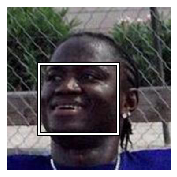

In [163]:
im_path, bb = lookingaway_images[15]
image = open_image(im_path)
image.show(y=ImageBBox.create(*image.size, tensor(bb)[None], scale=True))

In [138]:
def pad_points(bbox, pad): # pad - tensor([4])
    t,l,b,r = bbox
    h_face, w_face = map(int, [b-t, r-l])
    cc = tensor([(t+b)//2, (l+r)//2])
    offset = (tensor(bbox) - torch.cat([cc,cc])).abs()
    offset = (offset * PAD_PCT).long() # scale
    cc = torch.cat([cc,cc])
    t,l = cc[:2] - offset[:2]
    b,r = cc[2:] + offset[2:]
    return list(map(int, [t,l,b,r]))

In [173]:
PAD_PCT = tensor([1.4,1.1,1.1,1.1]) # t,l,b,r
out_path = Path('../data/icao/lookingaway_unlabeled/')
for images_and_bboxes, data_name in [(lookingaway_images_all,'LookingAway'), (lookingtocamera_images_all, 'LookingAhead')]:
    for im_path, (t,l,b,r) in progress_bar(images_and_bboxes):
        image = open_image(im_path)
        t,l,b,r = pad_points((t,l,b,r), PAD_PCT)
        t,l,b,r = max(t,0), max(l,0), min(b,image.data.shape[1]), min(r,image.data.shape[2])
        Image(image.data[:,t:b,l:r]).save(out_path/data_name/im_path.name)

# DarkFace

In [ ]:
images_dir = Path('/data/faces/CELEBA/images/img_align_celeba/')
for im_path in get_image_files(images_dir):
    image = open_image(im_path)
#     image.apply_tfms([crop_pad()], size=224, resize_method=ResizeMethod.CROP, padding_mode='zeros')
    if random.random() > 0.5: data_name = 'BrightFace'
    else: image, data_name = brightness(image, random.random()*0.2+0.05), 'DarkFace'
    image.show()
    break

# LFW

In [12]:
from facenet_pytorch import MTCNN
mtcnn = MTCNN(
    image_size=224, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=False,
    device='cuda'
)

from torchvision import datasets
class ImagesWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super().__getitem__(index)
        path = self.imgs[index][0]
        return (original_tuple + (path,))
    
def create_cropped_images(loader, output_dir):
    not_found_names = []
    for x, y, path in progress_bar(loader):
        name = Path(path).name
        try:Image(mtcnn(x)/255.).save(str(output_dir/name))
        except: not_found_names.append(Path(path).name)
    return not_found_names

In [19]:
lfw_images_dir = Path('/data/faces/LFW/lfw/')
lfw_cropped_dir = Path('../data/face/lfw_cropped_images/')

In [20]:
dataset = ImagesWithPath(str(lfw_images_dir))
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=lambda x: x[0], num_workers=1)
create_cropped_images(loader, lfw_cropped_dir)

[]

# OpenEyes

In [65]:
lfw_cropped_images_dir = Path('../data/face/lfw_cropped_images/')
attr_path = Path('/data/faces/LFW/lfw_attributes.txt')

In [66]:
attr_names = open(attr_path).readlines()[1][2:-1].split('\t')
print(attr_names)

['person', 'imagenum', 'Male', 'Asian', 'White', 'Black', 'Baby', 'Child', 'Youth', 'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair', 'Brown Hair', 'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses', 'Mustache', 'Smiling', 'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting', 'Flash', 'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair', 'Straight Hair', 'Receding Hairline', 'Bangs', 'Sideburns', 'Fully Visible Forehead', 'Partially Visible Forehead', 'Obstructed Forehead', 'Bushy Eyebrows', 'Arched Eyebrows', 'Narrow Eyes', 'Eyes Open', 'Big Nose', 'Pointy Nose', 'Big Lips', 'Mouth Closed', 'Mouth Slightly Open', 'Mouth Wide Open', 'Teeth Not Visible', 'No Beard', 'Goatee', 'Round Jaw', 'Double Chin', 'Wearing Hat', 'Oval Face', 'Square Face', 'Round Face', 'Color Photo', 'Posed Photo', 'Attractive Man', 'Attractive Woman', 'Indian', 'Gray Hair', 'Bags Under Eyes', 'Heavy Makeup', 'Rosy Cheeks', 'Shiny Skin', 'Pale Skin', "5 o' Clock Shadow", 'Strong Nose-Mouth Lines', 'Wearing Lipstick

In [67]:
idx = lambda name: attr_names.index(name)
idx('Eyes Open')

39

In [68]:
def append_zeros(s, num_chars=4):
    while True:
        if len(s) == num_chars: return s
        s = '0' + s

In [91]:
def print_stats(number_list):
    x = np.array(number_list)
    print(f'num elems: {len(x)}')
    print(f'max: {x.max()}, min: {x.min()}')
    print(f'>0: {(x>0).sum()}, <0: {(x<0).sum()}')

In [70]:
def normalize_vals(number_list):
    x = np.array(number_list)
    x[x>0] =  x[x>0]/x.max()
    x[x<0] = -x[x<0]/x.min()
    return x

In [71]:
def get_lfw_attributes(attribute='Eyes Open'):
    attr_images = []
    for line in open(attr_path).readlines()[2:]:
        attrs = line[:-1].split('\t')
        person, _id, eyes_open = map(lambda name: attrs[idx(name)], ('person','imagenum',attribute))
        person, _id = person.replace(' ', '_'), append_zeros(_id)
        im_path = lfw_cropped_images_dir/(person+'_'+_id+'.jpg')
        assert im_path.exists()
        attr_images.append((im_path, float(eyes_open)))
    return attr_images

num elems: 13143
max: 3.80094866407, min: -2.43275558472
>0: 11334, <0: 1809


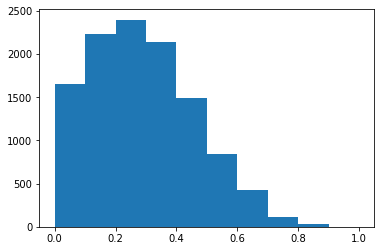

In [96]:
eye_open_images = get_lfw_attributes('Eyes Open')
print_stats([val for p,val in eye_open_images])
eye_open_values = normalize_vals([val for p,val in eye_open_images])
plot_histogram(eye_open_values[eye_open_values>0])
# print_stats(eye_open_values)
eye_open_images = [(p,val) for val, (p,_) in zip(eye_open_values, eye_open_images)]

In [98]:
output_dir = Path('../data/icao/eyesopen_lfw/')
for im_path,val in progress_bar(eye_open_images):
    data_name = 'EyesOpen' if val > 0 else 'EyesClosed'
    if data_name == 'EyesOpen' and val < 0.3: continue
    open_image(im_path).save(output_dir/data_name/im_path.name)

# Flash

num elems: 13143
max: 1.70016841361, min: -2.0701617919
>0: 2482, <=0: 10661


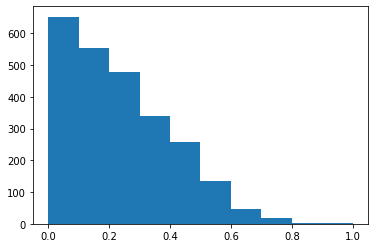

In [62]:
flash_images = get_lfw_attributes('Flash')
print_stats([val for p,val in flash_images])
flash_values = normalize_vals([val for p,val in flash_images])
plot_histogram(flash_values[flash_values>0])

In [63]:
output_dir = Path('../data/icao/flash_lfw/')
for im_path,val in progress_bar(flash_images):
    data_name = 'FlashOn' if val > 0 else 'FlashOff'
    open_image(im_path).save(output_dir/data_name/im_path.name)